# 1. Introduction

Treves Li

UC Berkeley

2025-08-17

This notebook provides the standard procedure for inverting EM data, using the EMagPy library.

# 2. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import re
from pathlib import Path

# Set root path
root_path = Path.cwd().parents[0]

# EMagPy libraries
from emagpy import Problem
from common_utils.emagpy_helpers import rename_cols_gem2emagpy, filter_close_points, filter_endpoints, filter_floor, smooth_savgol, truncate_inv_doi

We can choose any of:
* the raw, drift un-corrected data
* processed drift un-corrected data
* processed drifted and zeroed data

In [43]:
# Choose 
input_file = root_path / 'data' / 'processed' / '20260115_em_processed' / '1451_drifted_zeroed.csv' #TODO

df = pd.read_csv(input_file)

# 3. Process the Raw EM Data

## Rename headers

Headers are formatted as `<coilOrientation><coilSpacing>f<frequency>h<heightAboveGround><suffix>`. e.g.: `VCP0.32f30000h1` means the coils are in vertical coplanar (VCP) orientation, spaced by 0.32 meters, operated at a frequency of 300000 Hz and are at 1 meter above the ground surface.

With:
* `<coilOrientation>` could be: VCP (=HMD), HCP (=VMD) or PRP
* `<coilSpacing>` is the distance between the transmitter coil and the receiving coil expressed in meters
* `<frequency>` is th operating frequency in Hz
* `<heightaboveGround>` is the height at which the device was operated above the surface in meters
* `<suffix>` is optional and be set to `_inph` for inphase value in ppt or `_quad` for quadrature value in ppt

In [44]:
# Drop redundant columns
df = df[[col for col in df.columns if col in ['X', 'Y', 'Time[hhmmss.sss]'] or col.startswith(('I_', 'Q_'))]]

df = rename_cols_gem2emagpy(df, "horz", 1.66, 1)
em_cols = [col for col in df.columns if 'HCP' in col]

## Filter out close points

This step is key for reducing the number of points, and therefore reducing computation time.

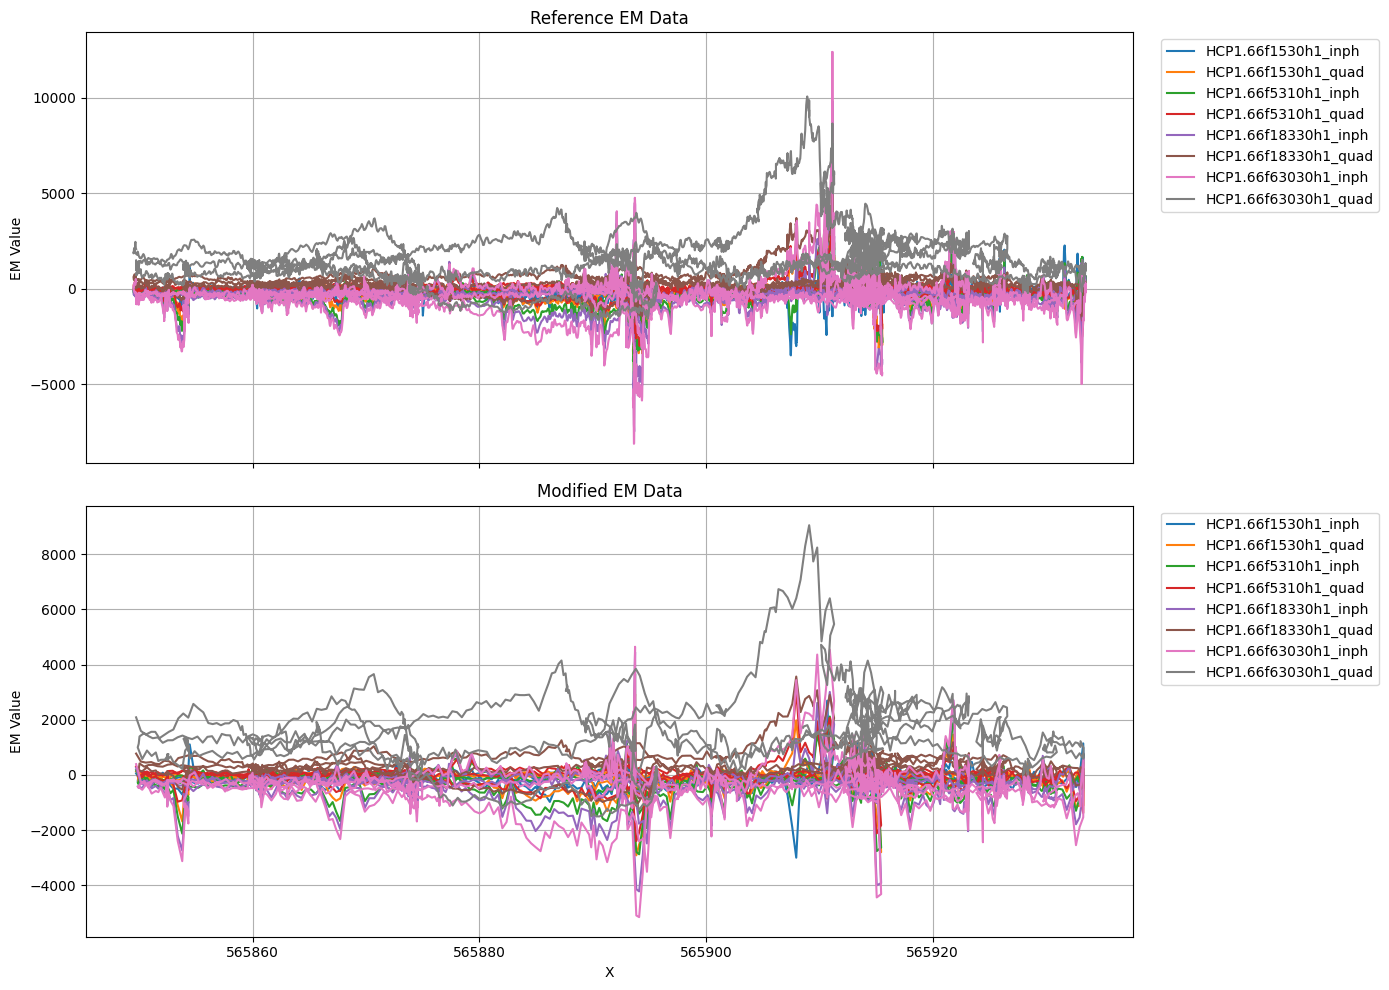

In [45]:
df = filter_close_points(df, tolerance=0.4, em_cols=em_cols, plot=True)

## Filter negative values (using floor)

In [36]:
# df_filter = filter_floor(df, cutoff=0, em_cols=em_cols, plot=True)

## Apply Savitzky-Golay smoothing

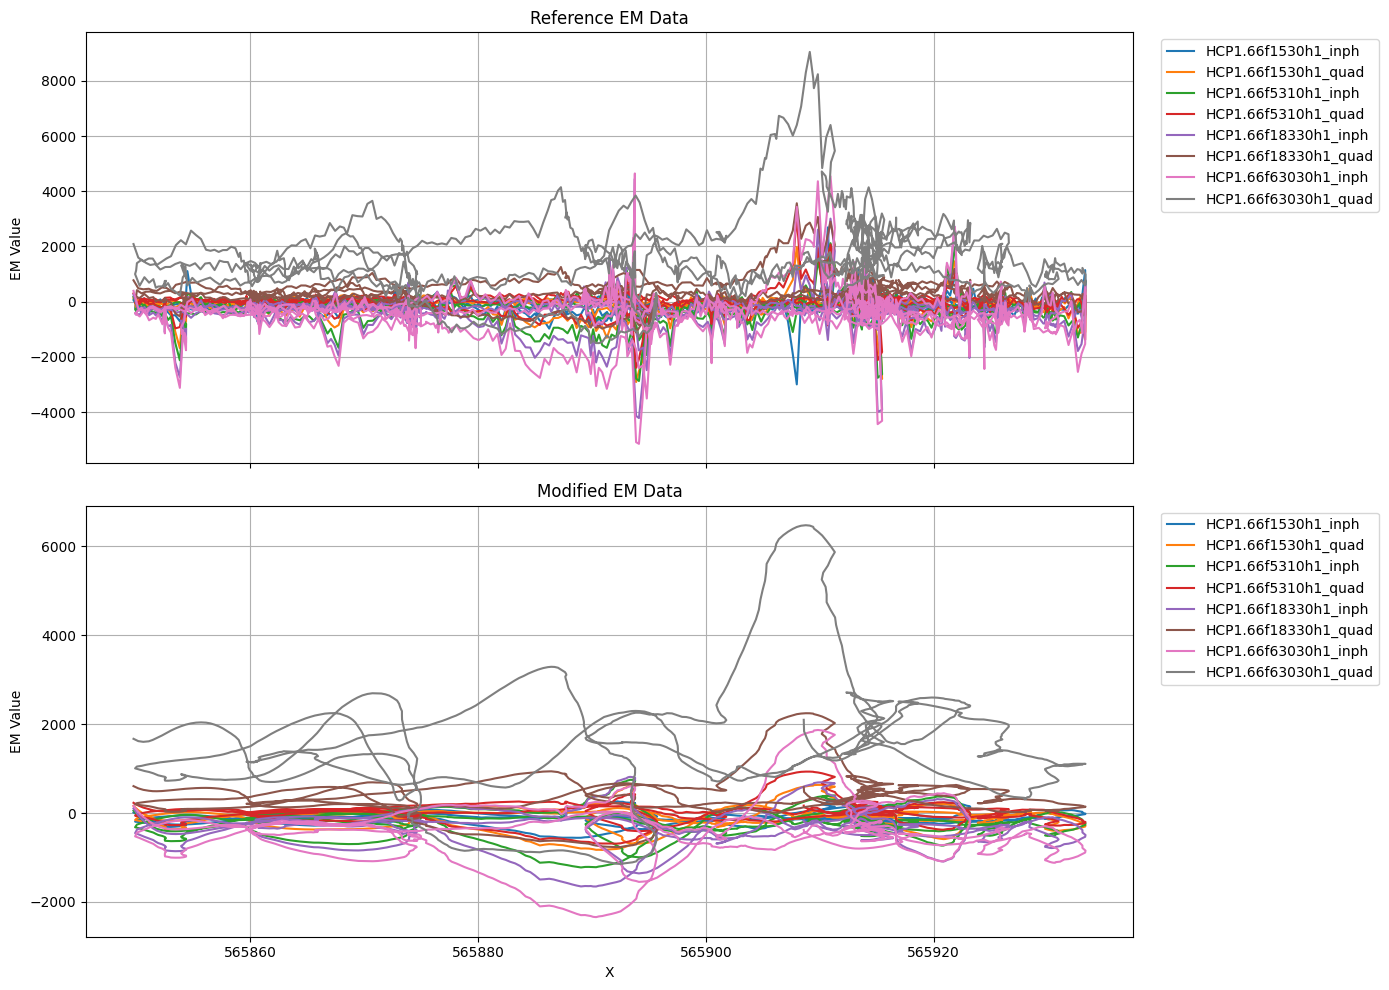

In [46]:
df = smooth_savgol(df, polyorder=7, em_cols=em_cols, window_length=101)

## Filter endpoints

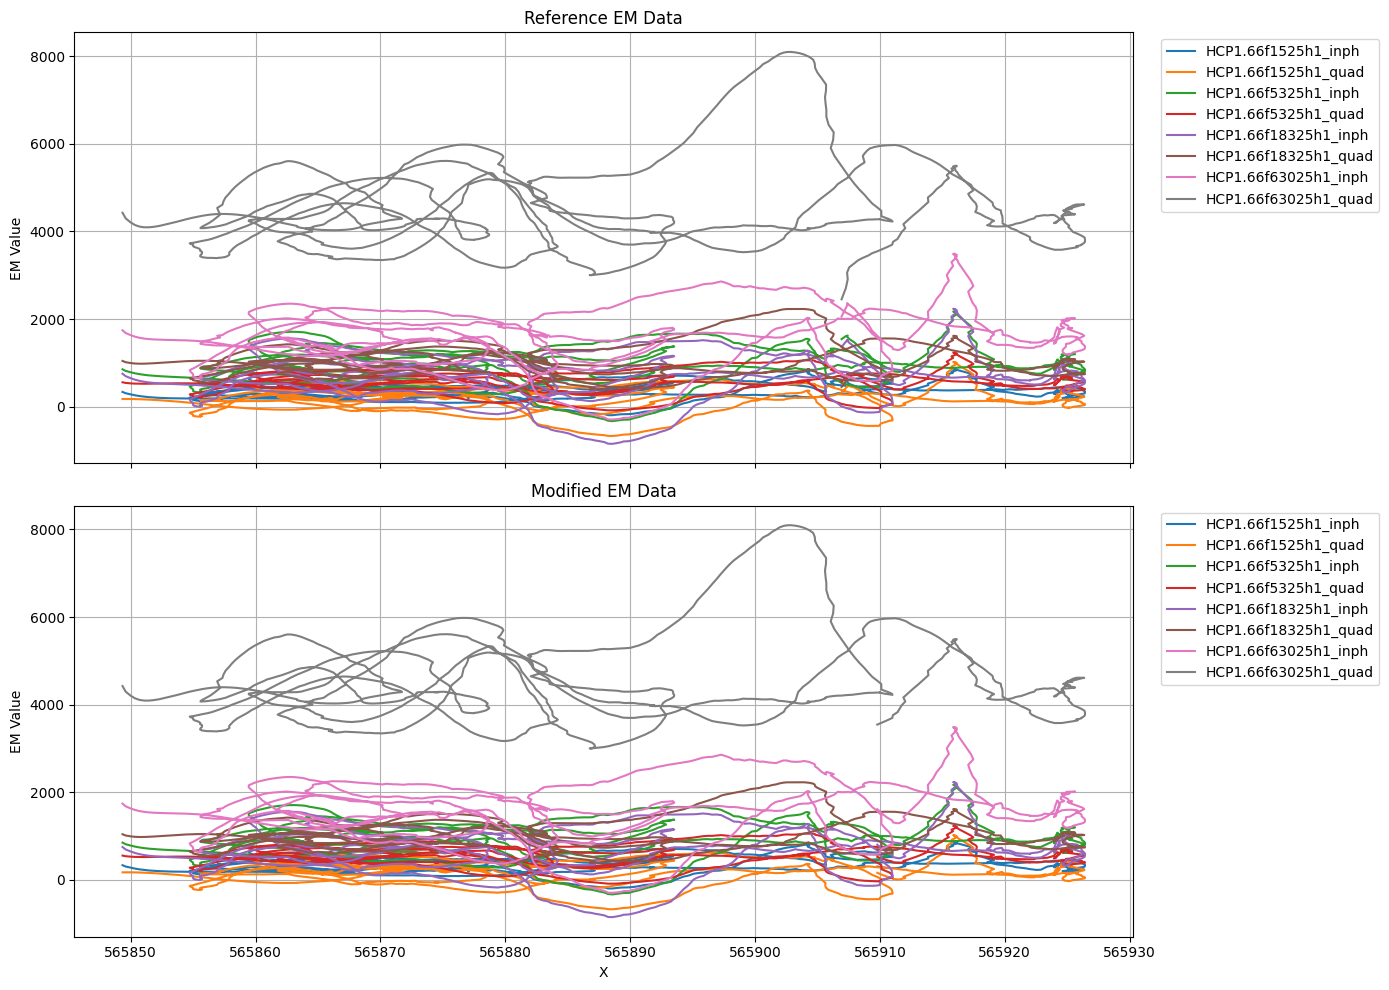

In [34]:
df_filter = filter_endpoints(df, n_start=0, n_end=10, em_cols=em_cols)

## Export the processed data

In [47]:
output_dir = root_path / 'data' / 'processed' / '20260115_em_processed'                          # TODO
output_dir.mkdir(parents=True, exist_ok=True)
output_name = re.sub(r'^(\d{4}(?:_drifted)?(?:_zeroed)?).*', r'\1_processed.csv', input_file.stem)
output_file = output_dir / output_name

df.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

Processed data saved to c:\Users\treve\OneDrive\Docs\Education\Masters and PhD\Research\04_big_c\data\processed\20260115_em_processed\1451_drifted_zeroed_processed.csv


# 4. Inversion

## Set up the EMagPy problem

Converting quadrature columns to LIN ECa. You can use "FSlin" or "Q" as forward model.


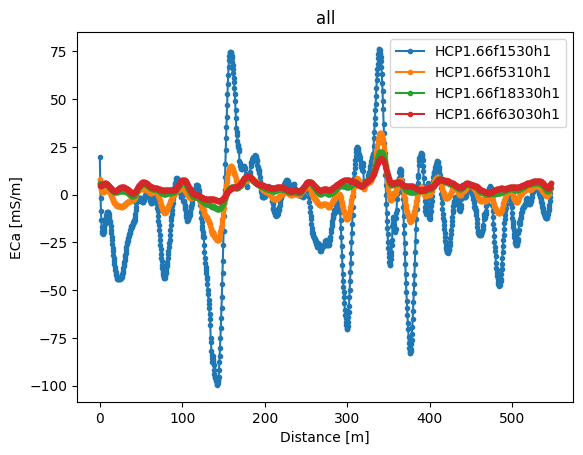

In [53]:
# Create the main object
k = Problem()

# Import the data
k.createSurvey(str(output_file), unit='ppm')
k.show()

## Coil filtering (as required)

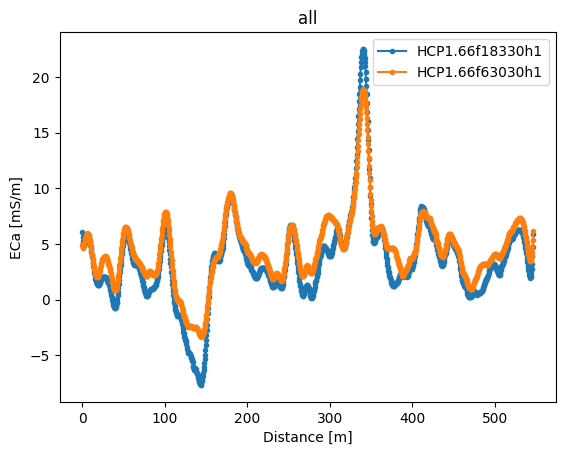

In [54]:
# k.removeCoil(4)
k.removeCoil(1)                       
k.removeCoil(0)                       # Remove lowest frequency

k.show()

## Perform the inversion

1274/1274 inverted

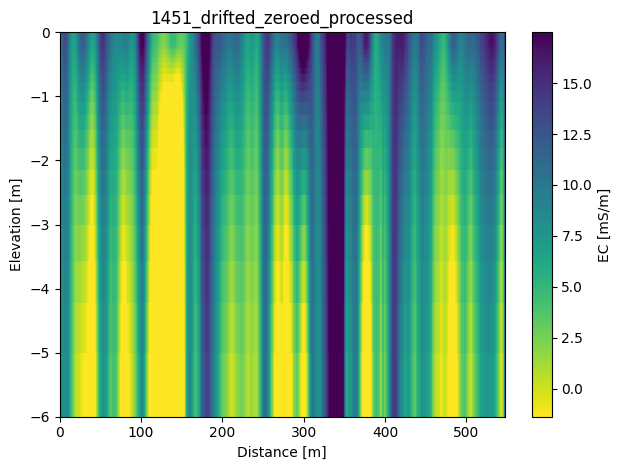

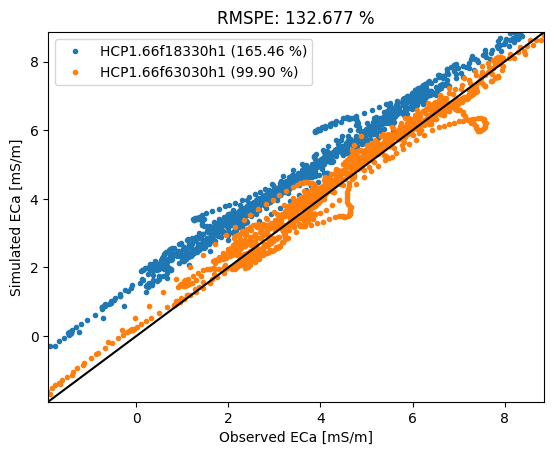

In [55]:
# Perform inversion
n_layers        = 20          # ≈ desired number of layers
top_boundary    = 0.20        # m  (bottom of first layer)
bottom_boundary = 5           # m  (top of half‑space / “infinite” layer) 
k.setInit(depths0=np.geomspace(top_boundary, bottom_boundary, n_layers))
k.invert(forwardModel='FSlin', method='Gauss-Newton')

# Save depth intervals for later
np.save(
    root_path / 'data' / 'processed' / '20260115_em_processed' / 'init_depths.npy',      # TODO
    np.geomspace(top_boundary, bottom_boundary, n_layers)
)

# Plot results
k.showResults(elev=True)
k.showOne2one()

## Calculate DOI

Computing DOI 1/1 done


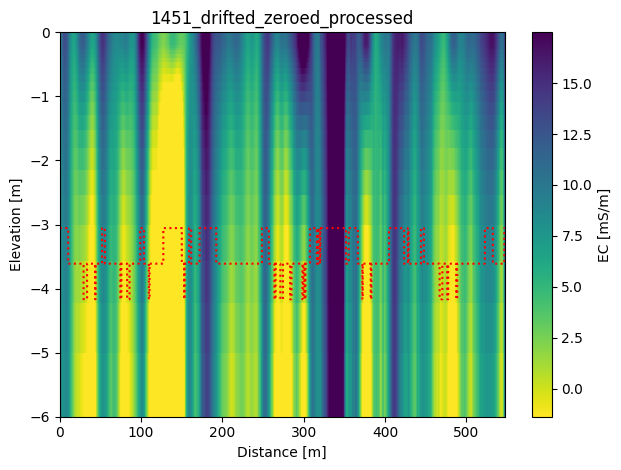

In [56]:
k.computeDOI(nlayers=10)
k.showResults(doi=True)

## Truncate at DOI

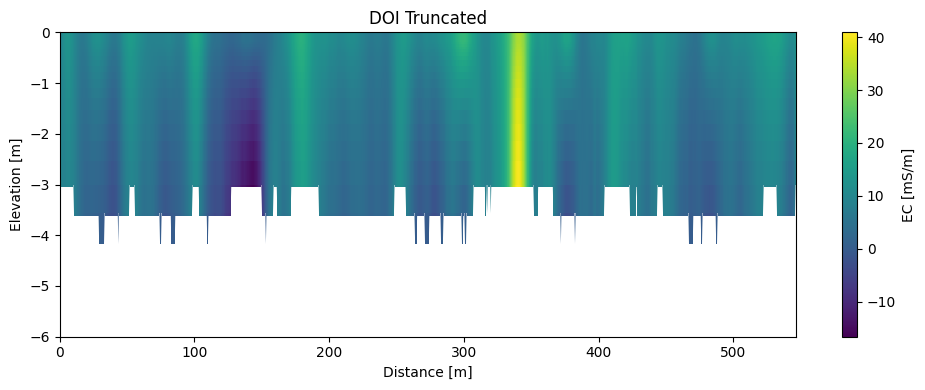

In [57]:
df_doi = truncate_inv_doi(k)

# 5. Export Inversion

In [58]:
output_name = re.sub(r'^(\d{4}(?:_drifted)?(?:_zeroed)?).*', r'\1_processed_inv_doi_rmse133pc.csv', input_file.stem) # TODO
output_file = output_dir / output_name

df_doi.to_csv(output_file, index=False)
print(f"Inversion DOI data saved to {output_name}")

Inversion DOI data saved to 1451_drifted_zeroed_processed_inv_doi_rmse133pc.csv
